In [1]:
import sys
sys.path.append('cocoapi\PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms
from torchvision.utils import make_grid, save_image
import os
# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          
    transforms.CenterCrop(224),                             
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test, mode='test')

C:\Users\ACER\anaconda3\envs\deepLearning\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ACER\anaconda3\envs\deepLearning\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\ACER\anaconda3\envs\deepLearning\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Vocabulary successfully loaded from vocab.pkl file!


In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
#     print(features)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)
    return features

def clean_sentence(output):
    sentence = ""
    for idx in output:
        if idx == 0:
            continue
        if idx == 1:
            break
        word = data_loader.dataset.vocab.idx2word[idx]
        sentence = sentence + word + ' '
        
    return sentence

def fetch_image(file_name):
    orig_image = Image.open(file_name).convert('RGB')
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    transform_test = transforms.Compose([ 
        transforms.Resize(256),                          
        transforms.CenterCrop(224),                             
        transforms.ToTensor(),                           
        transforms.Normalize((0.485, 0.456, 0.406),      
                             (0.229, 0.224, 0.225))])
    input_image = transform_test(orig_image)
    return orig_image, input_image

def generate_caption(input_image,encoder):
    print(input_image.shape)
    features = encoder(input_image).unsqueeze(1)
    features.to(device)
#     print(features.shape)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


INITIALIZING THE INPUT

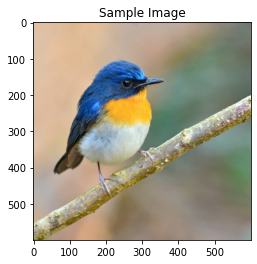

In [4]:
import os
file_name = 'bird.jpg'
address = os.path.join(os.getcwd(),'images',file_name)
orig_image, input_image = fetch_image(address)

IMPORTING THE MODEL

In [31]:
input_image.shape

torch.Size([3, 224, 224])

In [5]:
%load_ext autoreload
%autoreload 2

import os
import torch
from model_tree_saliency import EncoderCNN_b ,DecoderRNN_b

# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-1.pkl'
decoder_file = 'decoder-1.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 512
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN_b(embed_size)
encoder.eval()
decoder = DecoderRNN_b(embed_size, hidden_size, vocab_size)
decoder.eval()
print(os.getcwd())
address = os.path.join(os.getcwd(),'models', encoder_file)
print(address)
# Load the trained weights.
encoder.load_state_dict(torch.load(address))
decoder.load_state_dict(torch.load(os.path.join(os.getcwd(),'models', decoder_file)))

# Move models to GPU if CUDA is available.      
encoder.to(device)
decoder.to(device)
# encoder.zero_grad()
# decoder.zero_grad()

# print(clean_sentence(caption))
from lstm_saliency_tree import Saliency

target_layer = [*encoder.children()][0][-2][0].conv1
saliency_object = Saliency(encoder,decoder,target_layer)
cap_sal_dict = saliency_object(input_image.reshape(1,3,224,224).to('cuda'))

Vocabulary successfully loaded from vocab.pkl file!
9 2048
C:\Users\ACER\PycharmProjects\eXplainable_Image_Captioning
C:\Users\ACER\PycharmProjects\eXplainable_Image_Captioning\models\encoder-1.pkl
Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)


C:\Users\ACER\anaconda3\envs\deepLearning\lib\site-packages\torch\nn\modules\module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [12]:
from utils import visualize_cam
from datetime import datetime
## function to generate the captions for all the timestamps
def create_saliency_map(caption,saliency_maps):
    images_=[]
    for saliency_map in saliency_maps:
        saliency_map.cpu()
        heatmap_t, result_t = visualize_cam(saliency_map.cpu(),input_image.cpu())
        images_.append(torch.stack([input_image.squeeze().cpu(),heatmap_t,result_t],0))
    images = make_grid(torch.cat(images_,0),nrow=3)
    
    output_dir = 'outputs'
    os.makedirs(output_dir, exist_ok=True)
    now = datetime.now()
    dt_string = now.strftime("%H_%M_%S")
    output_name = caption.replace(" ", "_") + dt_string + "_lstm_output.JPEG"
    output_path = os.path.join(output_dir, output_name)
    save_image(images, output_path)

In [13]:
for keys in cap_sal_dict:
#     create_saliency_map(keys,cap_sal_dict[keys])
    print(keys)

a white bird sitting on top of a branch . 
a white bird sitting on top of a tree branch . 
a white bird sitting on top of a wooden table . 
a small bird sitting on a branch in a tree . 
a small bird is perched on a branch 


In [8]:
import nltk

is_noun = lambda pos: pos[:2] == 'NN'


for keys in cap_sal_dict:
    tokenized = nltk.word_tokenize(keys)
    nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
    
    print(nouns)

['bird', 'top', 'branch']
['bird', 'top', 'branch']
['bird', 'top', 'table']
['bird', 'branch', 'tree']
['bird', 'branch']


In [18]:
for keys in cap_sal_dict:
    keys = keys.split()
    keys.pop(0)
    print(keys)

['white', 'bird', 'sitting', 'on', 'top', 'of', 'a', 'branch', '.']
['white', 'bird', 'sitting', 'on', 'top', 'of', 'a', 'tree', 'branch', '.']
['white', 'bird', 'sitting', 'on', 'top', 'of', 'a', 'wooden', 'table', '.']
['small', 'bird', 'sitting', 'on', 'a', 'branch', 'in', 'a', 'tree', '.']
['small', 'bird', 'is', 'perched', 'on', 'a', 'branch']


In [9]:
list(cap_sal_dict.keys())[0]

'a white bird sitting on top of a branch . '

ADDING ALL THE SALIENCY MAPS GENERATED FOR ONE CAPTION

In [14]:
caption = list(cap_sal_dict.keys())[0]
saliency_maps = cap_sal_dict[caption]
saliency_maps[0].shape
cap_sal_dict[caption].pop(0)

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0765, 0.0765, 0.0765],
          [0.0000, 0.0000, 0.0000,  ..., 0.0765, 0.0765, 0.0765],
          [0.0000, 0.0000, 0.0000,  ..., 0.0765, 0.0765, 0.0765],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.2058, 0.2058, 0.2058],
          [0.0000, 0.0000, 0.0000,  ..., 0.2058, 0.2058, 0.2058],
          [0.0000, 0.0000, 0.0000,  ..., 0.2058, 0.2058, 0.2058]]]],
       device='cuda:0')

In [15]:
# caption = list(cap_sal_dict.keys())[0]
# print(caption)
# removing the saliency map of <start> token
print(len(cap_sal_dict[caption]))
caption_list = caption.split()
print(caption_list)
token_sal_dict = {}
for i in range(len(caption_list)):
    token_sal_dict[caption_list[i]] = cap_sal_dict[caption][i]
    

10
['a', 'white', 'bird', 'sitting', 'on', 'top', 'of', 'a', 'branch', '.']


In [17]:
token_sal_dict['a'].shape

torch.Size([1, 1, 224, 224])

In [51]:
token_sal_dict['bird'].shape

torch.Size([1, 1, 224, 224])

In [78]:
b = token_sal_dict['branch'] > 0.3
x_min = torch.min(b.nonzero()[:,2])
x_max = torch.max(b.nonzero()[:,2])
y_min = torch.min(b.nonzero()[:,3])
y_max = torch.max(b.nonzero()[:,3])
print(x_min,x_max,y_min,y_max)

tensor(0, device='cuda:0') tensor(223, device='cuda:0') tensor(0, device='cuda:0') tensor(223, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


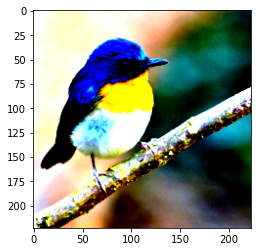

In [79]:
image1 = input_image[:,x_min:x_max,y_min:y_max].cpu().detach().numpy()
plt.imshow(np.swapaxes(np.swapaxes(image1,0,1),1,2))

In [48]:
image1 = input_image.cuda()*b[0]

In [64]:
plt.imshow(np.swapaxes(np.swapaxes(image1.cpu().detach().numpy(),0,1),1,2))

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [50]:
input_image

tensor([[[ 1.7009,  1.7180,  1.7352,  ..., -0.1657, -0.1828, -0.1828],
         [ 1.7009,  1.7180,  1.7352,  ..., -0.1999, -0.2171, -0.1999],
         [ 1.7180,  1.7352,  1.7352,  ..., -0.2342, -0.2513, -0.2171],
         ...,
         [ 1.4098,  1.5297,  1.5468,  ...,  0.2967,  0.3138,  0.2967],
         [ 1.3584,  1.2557,  1.2899,  ...,  0.3481,  0.3481,  0.3481],
         [ 1.3584,  1.2214,  1.0159,  ...,  0.3823,  0.3652,  0.3823]],

        [[ 1.3256,  1.3431,  1.3431,  ...,  0.1352,  0.1176,  0.1176],
         [ 1.3256,  1.3256,  1.3081,  ...,  0.1176,  0.1176,  0.1176],
         [ 1.3256,  1.3081,  1.3081,  ...,  0.1001,  0.0826,  0.1176],
         ...,
         [ 1.5707,  1.6583,  1.5882,  ...,  0.2577,  0.2752,  0.2577],
         [ 1.3782,  1.2381,  1.2206,  ...,  0.3102,  0.2927,  0.2927],
         [ 1.2906,  1.1506,  0.8880,  ...,  0.3277,  0.3102,  0.2752]],

        [[ 1.0539,  1.0714,  1.0714,  ...,  0.1651,  0.1476,  0.1825],
         [ 1.0539,  1.0539,  1.0539,  ...,  0

In [57]:
import torchvision.transforms.functional as F

image_output = F.crop(input_image,92,52,109-92,76-52)

In [56]:
image_output.shape

torch.Size([3, 17, 24])

In [58]:
import torchvision.transforms as T

transforms = T.ToPILImage()

img = transforms(image_output)
img.show()